In [1]:
# 1. Clone and setup FBPINNs
!git clone https://github.com/thiae/FBPINNs.git
%cd FBPINNs
!python colab_setup.py

# 2. Navigate to poroelasticity and setup paths
%cd poroelasticity
!python setup_path.py

# 3. Validate everything works
!python simple_validation.py

Cloning into 'FBPINNs'...
remote: Enumerating objects: 689, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 689 (delta 218), reused 188 (delta 108), pack-reused 346 (from 2)
Receiving objects: 100% (689/689), 15.53 MiB | 41.30 MiB/s, done.
Resolving deltas: 100% (363/363), done.
/content/FBPINNs
FBPINNs Colab Setup
Setup method: auto

Installing dependencies...
  Detected Google Colab - using GPU JAX
  Installing jax[cuda12]>=0.4.8...
  SUCCESS: jax[cuda12]>=0.4.8 installed successfully
  Installing optax>=0.1.4...
  SUCCESS: optax>=0.1.4 installed successfully
  Installing numpy>=1.24.2...
  SUCCESS: numpy>=1.24.2 installed successfully
  Installing scipy>=1.10.1...
  SUCCESS: scipy>=1.10.1 installed successfully
  Installing matplotlib>=3.7.1...
  SUCCESS: matplotlib>=3.7.1 installed successfully
  Installing tensorboardX>=2.6...
  SUCCESS: tensorboardX>=2.6 installed successfully
  Installing ipython>=8.12.0...
 

In [2]:
# ENVIRONMENT SETUP AND IMPROVED CLASS IMPLEMENTATION
import os
import sys
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import optax

print(" Setting up FBPINNs path...")

# Get the FBPINNs root directory (parent of current directory)
current_dir = Path.cwd()
fbpinns_root = current_dir.parent

print(f"Current directory: {current_dir}")
print(f"FBPINNs root: {fbpinns_root}")

# Add FBPINNs root to Python path (for fbpinns imports)
if str(fbpinns_root) not in sys.path:
    sys.path.insert(0, str(fbpinns_root))
    print(f" Added {fbpinns_root} to Python path")

# Add current directory to Python path (for local imports)
if str(current_dir) not in sys.path:
    sys.path.insert(0, str(current_dir))
    print(f" Added {current_dir} to Python path")

# Test fbpinns import first
try:
    import fbpinns
    print(" fbpinns module successfully imported")
except ImportError as e:
    print(f" fbpinns import failed: {e}")
    raise

# Import FBPINNs components
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer

print(" All imports successful!")

 Setting up FBPINNs path...
Current directory: /content/FBPINNs/poroelasticity
FBPINNs root: /content/FBPINNs
 Added /content/FBPINNs to Python path
 Added /content/FBPINNs/poroelasticity to Python path
 fbpinns module successfully imported
 All imports successful!


In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import optax
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer, get_inputs, FBPINN_model_jit

class BiotCoupled2D(Problem):
    """
    Unified 2D Biot poroelasticity problem with transient flow and geomechanics.

    This class implements a homogeneous base model for coupled geomechanics and
    fluid flow in two spatial dimensions and time.  The network takes three
    inputs (x, y, t) and returns three outputs (u_x, u_y, p).  Hard Dirichlet
    boundary conditions are imposed for pressure on the left (injection) and
    right (far-field) boundaries and for displacement on the left and bottom
    boundaries.  Initial conditions are satisfied via a smooth ramp in time.

    The loss function enforces the quasi‑static momentum balance and the
    transient mass balance with a homogeneous permeability.  Storage effects
    enter via the Biot modulus M.
    """

    @staticmethod
    def init_params(E=5000.0, nu=0.25, alpha=0.8, k=1.0, mu=1.0, M=100.0):
        """Initialize material parameters for both mechanics and flow.

        Parameters
        ----------
        E : float
            Young's modulus (Pa).
        nu : float
            Poisson's ratio (dimensionless).
        alpha : float
            Biot coefficient (dimensionless).
        k : float
            Intrinsic permeability (mD or nondimensionalised).
        mu : float
            Fluid viscosity (Pa·s or nondimensionalised).
        M : float
            Biot modulus governing storage (Pa).  The specific storage is 1/M.

        Returns
        -------
        tuple
            A tuple of (static_params, trainable_params).  For this problem
            there are no trainable material parameters."""

        # Convert all parameters to JAX arrays for consistency and automatic
        # differentiation.  Using float32 avoids unnecessary promotions.
        E = jnp.array(E, dtype=jnp.float32)
        nu = jnp.array(nu, dtype=jnp.float32)
        alpha = jnp.array(alpha, dtype=jnp.float32)
        k = jnp.array(k, dtype=jnp.float32)
        mu = jnp.array(mu, dtype=jnp.float32)
        M = jnp.array(M, dtype=jnp.float32)

        # Elastic constants derived from E and nu
        G = E / (2.0 * (1.0 + nu))
        lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

        static_params = {
            # dims = (number of outputs, number of inputs)
            # outputs: (u_x, u_y, p); inputs: (x, y, t)
            "dims": (3, 3),
            "E": E,
            "nu": nu,
            "G": G,
            "lam": lam,
            "k": k,
            "mu": mu,
            "alpha": alpha,
            "M": M
        }
        trainable_params = {}
        return static_params, trainable_params

    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        """
        Apply hard constraints to satisfy boundary and initial conditions.

        The raw network output u(x, y, t) = [u_x, u_y, p] is transformed into
        physically meaningful fields that exactly satisfy Dirichlet boundary
        conditions and initial conditions.  A time dependent envelope ensures
        that the solution vanishes at t=0.

        Hard constraints enforced:

        - u_x(0, y, t) = 0 (fixed left boundary)
        - u_y(x, 0, t) = 0 (fixed bottom boundary)
        - u(x, y, 0) = 0 (initially undeformed)
        - p(0, y, t) = p_L(y, t) (injection boundary, time ramped)
        - p(1, y, t) = 0 (far field boundary)
        - p(x, y, 0) = p0(y) (initial pressure)

        Parameters
        ----------
        all_params : dict
            Dictionary containing all model parameters.
        x_batch : array_like, shape (N, 3)
            Coordinates (x, y, t) at which the network is evaluated.
        u : array_like, shape (N, 3)
            Raw network output before applying boundary conditions.

        Returns
        -------
        array_like, shape (N, 3)
            Constrained network output satisfying boundary and initial
            conditions.
        """

        x = x_batch[:, 0:1]
        y = x_batch[:, 1:2]
        t = x_batch[:, 2:3]

        ux_raw = u[:, 0:1]
        uy_raw = u[:, 1:2]
        p_raw = u[:, 2:3]

        # Smooth ramp function: S(0) = 0 and S(t) → 1 as t → 1.  This prevents
        # discontinuities at t=0 and enforces the initial condition u=0.
        def S(t):
          return 1.0 - jnp.exp(-5.0*jnp.clip(t, 0.0, 1.0))

        # Initial pressure profile p0(y).  For excess pressure formulation,
        # choose p0 = 0.  For hydrostatic baseline, set p0 = c0 * (1 - y).
        p0 = jnp.zeros_like(t)

        # Left boundary pressure p_L(y, t).  A Gaussian centred at injection_center
        # with width sigma, modulated by the ramp S(t).

        injection_center, sigma = 0.4, 0.08
        gauss_y = jnp.exp(-((y - injection_center)**2) / (2.0 * sigma**2))
        pL = p0 + S(t) * gauss_y
        # Right boundary pressure p_R(y, t) = 0 (far‑field)
        pR = p0 * 0.0

        # Hard Dirichlet conditions for displacement.  Multiplying by x and y
        # enforces u_x(0, ·, ·) = 0 and u_y(·, 0, ·) = 0, and multiplying by
        # S(t) ensures u = 0 at t=0.
        ux = S(t) * x * ux_raw
        uy = S(t) * x * y * uy_raw

        # Pressure ansatz combining initial condition, boundary conditions,
        # and learnable interior variation.  The factor x(1-x) ensures that
        # the interior term vanishes on x=0 and x=1 so it cannot violate
        # Dirichlet conditions.  Multiplication by S(t) enforces p = p0 at t=0.
        p = (
            p0
            + (1.0 - x) * (pL - p0)
            + x * (pR - p0)
            + x * (1.0 - x) * S(t) * p_raw
        )

        return jnp.concatenate([ux, uy, p], axis=-1)

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        """
        Sample interior and boundary points for the residual and specify
        required derivatives.

        This method is used by FBPINNs to generate collocation points and
        determine which derivatives of the network output are needed for the
        physics loss.  Interior points are sampled in (x, y, t).  Boundary
        points are still sampled but the boundary conditions are enforced
        exactly, so their derivatives are not used in the loss.
        """

        dom = all_params["static"].setdefault("domain", {})
        d = all_params["static"]["problem"]["dims"][1]
        dom.setdefault("xmin", jnp.zeros((d,), dtype=jnp.float32))
        dom.setdefault("xmax", jnp.ones((d,),  dtype=jnp.float32))
        dom.setdefault("xd", d)

        bs0 = batch_shapes[0]
        if sampler == "grid" and len(bs0) == 1 and d > 1:
            batch_shape_phys = (bs0[0],) * d
        else:
            batch_shape_phys = bs0

        # Sample interior collocation points in (x, y, t)
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shape_phys)

        # Derivatives needed for mechanics and flow equations.
        # Ordering here must match the unpacking in loss_fn.
        required_ujs_phys = (
            (0, (0,)),   # ∂ux/∂x
            (0, (0,0)),  # ∂²ux/∂x²
            (0, (1,1)),  # ∂²ux/∂y²
            (0, (0,1)),  # ∂²ux/(∂x∂y)
            (1, (1,)),   # ∂uy/∂y
            (1, (0,0)),  # ∂²uy/∂x²
            (1, (1,1)),  # ∂²uy/∂y²
            (1, (0,1)),  # ∂²uy/(∂x∂y)
            (2, (0,)),   # ∂p/∂x
            (2, (1,)),   # ∂p/∂y
            (2, (0,0)),  # ∂²p/∂x²
            (2, (1,1)),  # ∂²p/∂y²
            (2, (2,)),   # ∂p/∂t
            (0, (0,2)),  # ∂/∂t(∂ux/∂x)
            (1, (1,2)),  # ∂/∂t(∂uy/∂y)
        )

        # Sample boundary points.  Hard BCs mean we do not need derivatives
        # there, but sampling can be useful for diagnostics.
        boundary_batch_shapes = batch_shapes[1:5]
        try:
            x_batches_boundaries = domain.sample_boundaries(all_params, key, sampler, boundary_batch_shapes)
        except Exception:
            zeros = jnp.zeros((0, d), dtype=jnp.float32)
            x_batches_boundaries = [zeros, zeros, zeros, zeros]

        required_ujs_boundary = ((0, ()), (1, ()), (2, ()))

        return [
            [x_batch_phys, required_ujs_phys],
            [x_batches_boundaries[0], required_ujs_boundary],
            [x_batches_boundaries[1], required_ujs_boundary],
            [x_batches_boundaries[2], required_ujs_boundary],
            [x_batches_boundaries[3], required_ujs_boundary],
        ]

    @staticmethod
    def loss_fn(all_params, constraints):

        """
        Compute the mean squared residuals of the Biot equations.

        Mechanics residual:   ∇·σ = 0,  σ = 2G ε + λ tr(ε) I − α p I
        Flow residual:        (1/M) p_t + α ∂t(div u) − ∇·((k/μ) ∇p) = 0

        Homogeneous permeability (∇k = 0) is assumed in this base model.
        """

        prob = all_params["static"]["problem"]
        E, G, lam = prob["E"], prob["G"], prob["lam"]
        alpha, k, mu, M = prob["alpha"], prob["k"], prob["mu"], prob["M"]

        # Unpack derivatives according to the ordering in required_ujs_phys.
        (
        duxdx, d2uxdx2, d2uxdy2, d2uxdxdy,
        duydy, d2uydx2, d2uydy2, d2uydxdy,
        dpdx, dpdy, d2pdx2, d2pdy2,
        p_t, duxdx_t, duydy_t
        ) = constraints[0][1:16]

        # Divergence and its time derivative
        div_u   = duxdx + duydy
        div_u_t = duxdx_t + duydy_t
        lap_p   = d2pdx2 + d2pdy2

        # Momentum equilibrium residuals: ∇·σ=0 with σ = 2G ε + λ tr(ε) I − αp I  (keep the minus!)
        equilibrium_x = (
            (2 * G + lam) * d2uxdx2
            + lam * d2uydxdy
            + G * d2uxdy2
            + G * d2uydxdy
            - alpha * dpdx
            )
        equilibrium_y = (
            G * d2uxdxdy
            + G * d2uydx2
            + lam * d2uxdxdy
            + (2 * G + lam) * d2uydy2
            - alpha * dpdy)

       # Mass balance residual: (1/M) p_t + α ∂t(div u) − ∇·((k/μ)∇p) = 0  (homog. k => ∇k=0)
        darcy_div = (k / mu) * lap_p
        flow_residual = (p_t / M) + alpha * div_u_t - darcy_div

        # Characteristic scales to balance contributions
        L = 1.0
        p_scale = 1.0
        mech_scale = jnp.maximum(E / (L ** 2), 1e-6)
        flow_scale = jnp.maximum((k / mu) * (p_scale / (L ** 2)), 1e-8)

        mechanics_loss = jnp.mean((equilibrium_x / mech_scale) ** 2 + (equilibrium_y / mech_scale) ** 2)
        flow_loss = jnp.mean((flow_residual / flow_scale) ** 2)
        return mechanics_loss + flow_loss


    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        There is no closed form solution for this problem; return None.
        """
        return None


class BiotCoupledTrainer:
    """
    Training wrapper for the BiotCoupled2D problem with hard boundary conditions.

    This class configures the domain, decomposition, neural network, sampling,
    and training hyperparameters.  It exposes convenience methods for training,
    prediction, boundary verification, and plotting.
    """

    def __init__(self):
        # Define configuration for FBPINN.  We select a rectangular domain in
        # (x, y, t) ∈ [0,1]×[0,1]×[0,1] with overlapping subdomains for FBPINN.

        self.config = Constants(
            run="biot_coupled_2d",
            domain=RectangularDomainND,
            domain_init_kwargs={
                'xmin': jnp.array([0.0, 0.0, 0.0]),
                'xmax': jnp.array([1.0, 1.0, 1.0])
                },
            problem=BiotCoupled2D,
            problem_init_kwargs={
                'E': 5000.0,
                'nu': 0.25,
                'alpha': 0.8,
                'k': 1.0,
                'mu': 1.0,
                'M': 100.0
                },
            decomposition=RectangularDecompositionND,
            decomposition_init_kwargs={
                # Subdomain centres along x, y, and t. We use three splits in
                # each direction to balance resolution and overlap across space
                # and time.
                'subdomain_xs': [
                    jnp.linspace(0, 1, 3),
                    jnp.linspace(0, 1, 3),
                    jnp.linspace(0, 1, 3)
                    ],
                # Subdomain widths. An overlap of 0.8 in each dimension
                # promotes smooth stitching across subdomains. The third entry
                # applies to the time dimension as well.
                'subdomain_ws': [
                    0.8 * jnp.ones(3),
                    0.8 * jnp.ones(3),
                    0.8 * jnp.ones(3)
                    ],
                'unnorm': (0., 1.)
            },
            network=FCN,
            network_init_kwargs={
                # Increased network capacity: three hidden layers with 128 neurons
                # each, activated by tanh.  The network maps (x,y,t) → (u_x,u_y,p).
                'layer_sizes': [3, 128, 128, 128, 3],
                'activation': 'tanh'
                },
            # Sampling shapes: interior in (x,y,t).  We increase the number
            # of collocation points to (80,80,20) for x, y, and t.  The
            # boundary batches remain zero because BCs are hard enforced.
            ns=((80, 80, 20), (0,), (0,), (0,), (0,)),
            n_test=(20, 20, 5),
            n_steps=8000,
            optimiser_kwargs={'learning_rate': 1e-3},
            summary_freq=100,
            test_freq=250,
            show_figures=False,
            save_figures=False,
            clear_output=True
        )
        self.trainer = FBPINNTrainer(self.config)
        self.all_params = None

    def train(self, n_steps=None):
        """
        Train the PINN.  If n_steps is provided, override the configuration.
        """
        if n_steps is not None:
            self.config.n_steps = n_steps
            self.trainer.c.n_steps = n_steps
        print("Training with hard boundary constraints.")
        self.all_params = self.trainer.train()
        return self.all_params

    def predict(self, x_points, t=1.0):
        """
        Evaluate the trained network at specified points.  If x_points has
        shape (N,2), append a column of constant time t.
        """
        if self.all_params is None:
            raise ValueError("Model not trained yet")
        x_points = jnp.array(x_points)
        if x_points.shape[1] == 2:
            tcol = jnp.full((x_points.shape[0], 1), float(t))
            x_points = jnp.concatenate([x_points, tcol], axis=1)
        from fbpinns.analysis import FBPINN_solution
        active = jnp.ones(self.all_params["static"]["decomposition"]["m"], dtype=jnp.int32)
        return FBPINN_solution(self.config, self.all_params, active, x_points)

    def verify_bcs(self, n_points=100, t=1.0):

        """
        Evaluate the maximum violation of hard boundary conditions at time t.
        """

        print("\n" + "="*60)
        print(f"Boundary Conditon Verification at t={t}")
        print("="*60)

        y_test = jnp.linspace(0, 1, n_points)
        tcol = jnp.full((n_points, 1), float(t))

        left_points = jnp.column_stack([jnp.zeros(n_points), y_test, tcol.squeeze()])
        right_points = jnp.column_stack([jnp.ones(n_points), y_test, tcol.squeeze()])
        bottom_points = jnp.column_stack([jnp.linspace(0, 1, n_points), jnp.zeros(n_points), tcol.squeeze()])

        left_pred = self.predict(left_points)
        right_pred = self.predict(right_points)
        bottom_pred = self.predict(bottom_points)

        # Reconstruct the target left boundary pressure used in constraining_fn
        injection_center, sigma = 0.4, 0.08
        S = 1.0 - jnp.exp(-5.0*float(t))
        pL = S * jnp.exp(-((y_test - injection_center) ** 2) / (2 * sigma ** 2))

        print(f"Left boundary (x=0): ux=0, uy=0, p=pL(y,t)")
        print(f"  max|ux| = {jnp.max(jnp.abs(left_pred[:, 0])):.2e}")
        print(f"  max|uy| = {jnp.max(jnp.abs(left_pred[:, 1])):.2e}")
        print(f"  max|p - pL| = {jnp.max(jnp.abs(left_pred[:, 2] - pL)):.2e}")
        print(f"Right boundary (x=1): p=0")
        print(f"  max|p| = {jnp.max(jnp.abs(right_pred[:, 2])):.2e}")
        print(f"Bottom boundary (y=0): uy=0")
        print(f"  max|uy| = {jnp.max(jnp.abs(bottom_pred[:, 1])):.2e}")

        all_violations = [
            jnp.max(jnp.abs(left_pred[:, 0])),
            jnp.max(jnp.abs(left_pred[:, 1])),
            jnp.max(jnp.abs(left_pred[:, 2] - pL)),
            jnp.max(jnp.abs(right_pred[:, 2])),
            jnp.max(jnp.abs(bottom_pred[:, 1])),
        ]
        max_violation = max(all_violations)
        if max_violation < 1e-6:
            print("\nStatus: PERFECT - All BCs satisfied to machine precision")
        elif max_violation < 1e-3:
            print("\nStatus: EXCELLENT - All BCs satisfied within tolerance")
        elif max_violation < 1e-2:
            print("\nStatus: GOOD - Minor BC violations")
        else:
            print(f"\nStatus: CHECK - Max violation: {max_violation:.3e}")
        return max_violation < 1e-2

    def compute_physics_metrics(self, n_points=50, method='fd_xy_ad_t', t=1.0, chunk=4096):
        """
        Compute physics validation metrics on a regular grid.

        This routine evaluates the residuals of the quasi‑static mechanics
        equilibrium and the transient mass balance under the assumption that
        time derivatives are small at the chosen evaluation time.  It can
        operate using finite differences (default) or autodiff.  The sign
        convention here mirrors the training loss: the coupling term
        enters as −α∇p in the mechanics residual and there is no α∇p term
        in the flow residual (since ∂t(div u) and p_t are assumed zero).

        Parameters
        ----------
        n_points : int, optional
            Number of points along each spatial dimension for the evaluation grid.
        method : {'finite_diff', 'autodiff'}, optional
            Derivative computation method.  Finite difference is faster but
            less accurate; autodiff uses JAX for exact derivatives.

        Returns
        -------
        dict
            Dictionary containing absolute and relative residual metrics and
            diagnostic scales.

        Physics validation on a regular grid at time t.

        Modes
        -----
        'fd_xy_ad_t'  : finite differences in x,y + autodiff in t (transient-consistent).
        'steady_fd'   : your previous steady snapshot check (no time terms).
        'autodiff_all': full autodiff in x,y,t (most accurate, most memory).

        Notes
        -----
        - Mechanics residual uses   -alpha * grad(p)   (matches training loss).
        - Flow residual uses        p_t / M + alpha * d/dt(div u) - (k/mu) * lap(p).
        - Uses chunked vmap over t-derivatives to avoid OOM.
        """

        if self.all_params is None:
            raise ValueError("Model not trained yet")

        if method not in ('fd_xy_ad_t','steady_fd','autodiff_all'):
            raise ValueError("method must be one of {'fd_xy_ad_t','steady_fd','autodiff_all'}")

        print(f"Physics Validation Metrics (using {method})")

        # Grid (avoid edges for FD stencils)
        if method in ('fd_xy_ad_t','steady_fd'):
            x = jnp.linspace(0.1, 0.9, n_points)
            y = jnp.linspace(0.1, 0.9, n_points)
        else:
            x = jnp.linspace(0.0, 1.0, n_points)
            y = jnp.linspace(0.0, 1.0, n_points)

        X, Y = jnp.meshgrid(x, y)
        XYT = jnp.column_stack([X.flatten(), Y.flatten(), jnp.full((n_points*n_points,), float(t))])

        # Params and scales
        prob  = self.all_params["static"]["problem"]
        G     = prob["G"]; lam = prob["lam"]; alpha = prob["alpha"]
        k     = prob["k"]; mu  = prob["mu"];  E     = prob["E"]; M = prob.get("M", 1.0)

        pred  = self.predict(XYT)
        ux    = pred[:,0]; uy = pred[:,1]; p = pred[:,2]

        L = 1.0; p_scale = 1.0
        u_scale = jnp.maximum(jnp.max(jnp.abs(ux)), jnp.max(jnp.abs(uy)))
        u_scale = jnp.where(u_scale < 1e-10, p_scale * L / E, u_scale)

        mech_scale  = jnp.maximum(E * u_scale / L**2, 1e-8)
        darcy_scale = jnp.maximum((k/mu) * p_scale / L**2, 1e-10)

        # Helpers for FD in space
        dx = x[1]-x[0] if n_points>1 else 1.0
        dy = y[1]-y[0] if n_points>1 else 1.0
        ux_grid = ux.reshape(n_points, n_points)
        uy_grid = uy.reshape(n_points, n_points)
        p_grid  = p.reshape(n_points, n_points)

        def fd_grad_x(arr): return jnp.gradient(arr, dx, axis=1)
        def fd_grad_y(arr): return jnp.gradient(arr, dy, axis=0)
        def fd_lap(arr):
            return jnp.gradient(jnp.gradient(arr, dx, axis=1), dx, axis=1) + \
                  jnp.gradient(jnp.gradient(arr, dy, axis=0), dy, axis=0)

        # Spatial derivatives (FD)
        dux_dx  = fd_grad_x(ux_grid).flatten()
        dux_dy  = fd_grad_y(ux_grid).flatten()
        duy_dx  = fd_grad_x(uy_grid).flatten()
        duy_dy  = fd_grad_y(uy_grid).flatten()
        d2ux_dx2  = jnp.gradient(fd_grad_x(ux_grid), dx, axis=1).flatten()
        d2ux_dy2  = jnp.gradient(fd_grad_y(ux_grid), dy, axis=0).flatten()
        d2ux_dxdy = jnp.gradient(fd_grad_x(ux_grid), dy, axis=0).flatten()
        d2uy_dx2  = jnp.gradient(fd_grad_x(uy_grid), dx, axis=1).flatten()
        d2uy_dy2  = jnp.gradient(fd_grad_y(uy_grid), dy, axis=0).flatten()
        d2uy_dxdy = jnp.gradient(fd_grad_x(uy_grid), dy, axis=0).flatten()
        dp_dx     = fd_grad_x(p_grid).flatten()
        dp_dy     = fd_grad_y(p_grid).flatten()
        lap_p     = fd_lap(p_grid).flatten()
        div_u     = (dux_dx + duy_dy)

        if method == 'steady_fd':
            # Steady snapshot (no time terms)
            equilibrium_x = ((2*G + lam)*d2ux_dx2 + lam*d2uy_dxdy + G*d2ux_dy2 + G*d2uy_dxdy - alpha*dp_dx)
            equilibrium_y = (G*d2ux_dxdy + G*d2uy_dx2 + lam*d2ux_dxdy + (2*G + lam)*d2uy_dy2 - alpha*dp_dy)
            flow_residual = -(k/mu) * lap_p
            flow_scale = darcy_scale

        elif method == 'autodiff_all':
            # Full autodiff in x,y,t (costly)
            def comp(idx):
                def f(xyt): return self.predict(xyt.reshape(1,-1))[0, idx]
                return f
            # First space derivs
            d_ux_dx = jax.vmap(jax.grad(comp(0), argnums=0))(XYT)
            d_uy_dy = jax.vmap(jax.grad(comp(1), argnums=1))(XYT)
            dp_dx   = jax.vmap(jax.grad(comp(2), argnums=0))(XYT)
            dp_dy   = jax.vmap(jax.grad(comp(2), argnums=1))(XYT)
            # Second space derivs
            d2_ux_dx2 = jax.vmap(jax.grad(jax.grad(comp(0), argnums=0), argnums=0))(XYT)
            d2_ux_dy2 = jax.vmap(jax.grad(jax.grad(comp(0), argnums=1), argnums=1))(XYT)
            d2_ux_dxdy= jax.vmap(jax.grad(jax.grad(comp(0), argnums=0), argnums=1))(XYT)
            d2_uy_dx2 = jax.vmap(jax.grad(jax.grad(comp(1), argnums=0), argnums=0))(XYT)
            d2_uy_dy2 = jax.vmap(jax.grad(jax.grad(comp(1), argnums=1), argnums=1))(XYT)
            d2_uy_dxdy= jax.vmap(jax.grad(jax.grad(comp(1), argnums=0), argnums=1))(XYT)
            d2_p_dx2  = jax.vmap(jax.grad(jax.grad(comp(2), argnums=0), argnums=0))(XYT)
            d2_p_dy2  = jax.vmap(jax.grad(jax.grad(comp(2), argnums=1), argnums=1))(XYT)
            # Time derivatives
            p_t      = jax.vmap(jax.grad(comp(2), argnums=2))(XYT)
            ux_t     = jax.vmap(jax.grad(comp(0), argnums=2))(XYT)
            uy_t     = jax.vmap(jax.grad(comp(1), argnums=2))(XYT)
            # div u_t
            dux_dx_t = jax.vmap(jax.grad(lambda xyt: jax.grad(comp(0), argnums=2)(xyt), argnums=0))(XYT)
            duy_dy_t = jax.vmap(jax.grad(lambda xyt: jax.grad(comp(1), argnums=2)(xyt), argnums=1))(XYT)
            equilibrium_x = ((2*G + lam)*d2_ux_dx2 + lam*d2_uy_dxdy + G*d2_ux_dy2 + G*d2_uy_dxdy - alpha*dp_dx)
            equilibrium_y = (G*d2_ux_dxdy + G*d2_uy_dx2 + lam*d2_ux_dxdy + (2*G + lam)*d2_uy_dy2 - alpha*dp_dy)
            lap_p         = d2_p_dx2 + d2_p_dy2
            flow_residual = (p_t / M) + alpha*(dux_dx_t + duy_dy_t) - (k/mu)*lap_p
            # flow scale: combine the three contributions
            Tchar = 1.0
            s_pt   = p_scale / (M*Tchar + 1e-12)
            s_comp = alpha * (u_scale / (L*Tchar + 1e-12))
            flow_scale = jnp.sqrt(darcy_scale**2 + s_pt**2 + s_comp**2)

        else:  # 'fd_xy_ad_t'  (recommended)
            # Autodiff in t via a single JVP over the full XYT grid + FD in x,y.
            # This avoids per-point shape changes during autodiff and is JAX-JIT friendly.

            # Precompute takes/cuts once on the whole grid to keep shapes static
            m = self.config.decomposition_init_kwargs['subdomain_xs'][0].shape[0] * \
                self.config.decomposition_init_kwargs['subdomain_xs'][1].shape[0]
            active_all = jnp.ones(self.all_params["static"]["decomposition"]["m"], dtype=jnp.int32)
            takes, _, (_, _, _, cut_all, _)  = get_inputs(XYT, active_all, self.all_params, self.config.decomposition)

            # Build a batched predictor using fixed takes/cuts
            def predict_batch(xyt_batch):
                all_params_cut = {
                    "static": cut_all(self.all_params["static"]),
                    "trainable": cut_all(self.all_params["trainable"]),
                }
                norm_fn, network_fn = self.config.decomposition.norm_fn, self.config.network.network_fn
                unnorm_fn, window_fn = self.config.decomposition.unnorm_fn, self.config.decomposition.window_fn
                constraining_fn = self.config.problem.constraining_fn
                model_fns = (norm_fn, network_fn, unnorm_fn, window_fn, constraining_fn)
                u, *_ = FBPINN_model_jit(all_params_cut, xyt_batch, takes, model_fns, verbose=False)
                return u

            # JVP in the direction of +t
            V = jnp.zeros_like(XYT)
            V = V.at[:, 2].set(1.0)
            _, dudt = jax.jvp(predict_batch, (XYT,), (V,))

            # Extract components and compute spatial derivatives of time-derivatives
            p_t  = dudt[:, 2]
            ux_t = dudt[:, 0].reshape(n_points, n_points)
            uy_t = dudt[:, 1].reshape(n_points, n_points)

            dux_dx_t = fd_grad_x(ux_t).flatten()
            duy_dy_t = fd_grad_y(uy_t).flatten()

            equilibrium_x = ((2*G + lam)*d2ux_dx2 + lam*d2uy_dxdy + G*d2ux_dy2 + G*d2uy_dxdy - alpha*dp_dx)
            equilibrium_y = (G*d2ux_dxdy + G*d2uy_dx2 + lam*d2ux_dxdy + (2*G + lam)*d2uy_dy2 - alpha*dp_dy)
            flow_residual = (p_t / M) + alpha*(dux_dx_t + duy_dy_t) - (k/mu)*lap_p

            Tchar = 1.0
            s_pt   = p_scale / (M*Tchar + 1e-12)
            s_comp = alpha * (u_scale / (L*Tchar + 1e-12))
            flow_scale = jnp.sqrt(darcy_scale**2 + s_pt**2 + s_comp**2)

        # Metrics
        mech_x_rms = jnp.sqrt(jnp.mean(equilibrium_x**2))
        mech_y_rms = jnp.sqrt(jnp.mean(equilibrium_y**2))
        mech_rms   = jnp.sqrt(0.5*(mech_x_rms**2 + mech_y_rms**2))
        flow_rms   = jnp.sqrt(jnp.mean(flow_residual**2))

        mech_x_linf = jnp.max(jnp.abs(equilibrium_x))
        mech_y_linf = jnp.max(jnp.abs(equilibrium_y))
        mech_linf   = jnp.maximum(mech_x_linf, mech_y_linf)
        flow_linf   = jnp.max(jnp.abs(flow_residual))

        mech_x_rel = mech_x_rms / mech_scale
        mech_y_rel = mech_y_rms / mech_scale
        mech_rel   = mech_rms / mech_scale
        flow_rel   = flow_rms / jnp.maximum(flow_scale, 1e-12)
        total_rel  = 0.5*(mech_rel + flow_rel)

        status = ("EXCELLENT" if total_rel < 1e-3 else
                  "VERY GOOD" if total_rel < 1e-2 else
                  "GOOD"      if total_rel < 5e-2 else
                  "ACCEPTABLE"if total_rel < 1e-1 else
                  "NEEDS IMPROVEMENT")

        print("\n┌─────────────────┬──────────────┬──────────────┬──────────────┐")
        print("  │ Equation        │ RMS Absolute │ RMS Relative │ L-inf Norm   │")
        print("  ├─────────────────┼──────────────┼──────────────┼──────────────┤")
        print(f" │ Mechanics (x)   │ {mech_x_rms:.2e} │ {mech_x_rel:.2e} │ {mech_x_linf:.2e} │")
        print(f" │ Mechanics (y)   │ {mech_y_rms:.2e} │ {mech_y_rel:.2e} │ {mech_y_linf:.2e} │")
        print(f" │ Mechanics (avg) │ {mech_rms:.2e} │ {mech_rel:.2e} │ {mech_linf:.2e} │")
        print(f" │ Flow            │ {flow_rms:.2e} │ {flow_rel:.2e} │ {flow_linf:.2e} │")
        print("  └─────────────────┴──────────────┴──────────────┴──────────────┘")
        print(f"\nCharacteristic Scales:")
        print(f"  Domain size (L): {L:.2f}")
        print(f"  Pressure scale: {p_scale:.2f}")
        print(f"  Displacement scale: {u_scale:.2e}")
        print(f"  Elastic force scale: {mech_scale:.2e}")
        print(f"  Flow scale (combined): {flow_scale:.2e}")
        print(f"\nOverall physics satisfaction: {status} (avg relative error: {total_rel:.2e})")

        if method in ('fd_xy_ad_t','steady_fd'):
            self.last_residuals = {
                'x': X, 'y': Y,
                'mechanics_x': equilibrium_x.reshape(n_points, n_points),
                'mechanics_y': equilibrium_y.reshape(n_points, n_points),
                'flow': flow_residual.reshape(n_points, n_points),
                'div_u': div_u.reshape(n_points, n_points)
            }

        print("="*60)

        return {
            'mechanics_x_rms': float(mech_x_rms),
            'mechanics_y_rms': float(mech_y_rms),
            'mechanics_rms'  : float(mech_rms),
            'flow_rms'       : float(flow_rms),
            'mechanics_x_linf': float(mech_x_linf),
            'mechanics_y_linf': float(mech_y_linf),
            'mechanics_linf'  : float(mech_linf),
            'flow_linf'       : float(flow_linf),
            'mechanics_x_rel' : float(mech_x_rel),
            'mechanics_y_rel' : float(mech_y_rel),
            'mechanics_rel'   : float(mech_rel),
            'flow_rel'        : float(flow_rel),
            'total_rel'       : float(total_rel),
            'status'          : status,
            'u_scale'         : float(u_scale),
            'p_scale'         : float(p_scale),
            'method'          : method
        }

    def check_bc_satisfaction(self):
        """
        Quickly evaluate boundary condition satisfaction for convergence history.

        This method samples a small number of points on the domain boundaries
        and compares the predicted solution against the imposed Dirichlet
        conditions.  For the left boundary, the target pressure profile pL
        (Gaussian injection with time ramp) is reconstructed and used in the
        comparison.  The default evaluation time is t=1.0.
        """
        if self.all_params is None:
            raise ValueError("Model not trained yet")
        n = 20
        y_test = jnp.linspace(0.0, 1.0, n)
        x_test = jnp.linspace(0.0, 1.0, n)
        # Build points with t=1.0
        tcol = jnp.ones((n, 1))
        left_points = jnp.column_stack([jnp.zeros(n), y_test, tcol.squeeze()])
        right_points = jnp.column_stack([jnp.ones(n), y_test, tcol.squeeze()])
        bottom_points = jnp.column_stack([x_test, jnp.zeros(n), tcol.squeeze()])
        # Predict
        left_pred = self.predict(left_points)
        right_pred = self.predict(right_points)
        bottom_pred = self.predict(bottom_points)
        # Target left boundary pressure
        injection_center, sigma = 0.4, 0.08
        S = 1.0 - jnp.exp(-5.0 * 1.0)
        pL = S * jnp.exp(-((y_test - injection_center) ** 2) / (2.0 * sigma ** 2))
        violations = [
            jnp.max(jnp.abs(left_pred[:, 0])),      # ux at x=0
            jnp.max(jnp.abs(left_pred[:, 1])),      # uy at x=0
            jnp.max(jnp.abs(left_pred[:, 2] - pL)),  # p at x=0
            jnp.max(jnp.abs(right_pred[:, 2])),     # p at x=1
            jnp.max(jnp.abs(bottom_pred[:, 1]))     # uy at y=0
        ]
        return {
            'max_violation': float(max(violations)),
            'all_violations': violations
        }

    def plot_solution(self, n_points=50, t=1.0, depth_style=True):
        x = jnp.linspace(0, 1, n_points); y = jnp.linspace(0, 1, n_points)
        X, Y = jnp.meshgrid(x, y)
        XYT = jnp.column_stack([X.flatten(), Y.flatten(), jnp.full((n_points*n_points,), float(t))])

        pred = self.predict(XYT)
        UX = pred[:,0].reshape(n_points, n_points)
        UY = pred[:,1].reshape(n_points, n_points)
        P  = pred[:,2].reshape(n_points, n_points)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        c1 = axes[0].contourf(X, Y, UX*1000.0, levels=20, cmap='RdBu')
        axes[0].set_title('Horizontal disp $u_x$ [mm]'); axes[0].set_xlabel('x'); axes[0].set_ylabel('y'); plt.colorbar(c1, ax=axes[0])

        c2 = axes[1].contourf(X, Y, UY*1000.0, levels=20, cmap='RdBu')
        axes[1].set_title('Uplift $u_y$ [mm] (positive up)'); axes[1].set_xlabel('x'); axes[1].set_ylabel('y'); plt.colorbar(c2, ax=axes[1])

        c3 = axes[2].contourf(X, Y, P, levels=20, cmap='plasma')
        axes[2].set_title('Pressure p [nondim or MPa]'); axes[2].set_xlabel('x'); axes[2].set_ylabel('y'); plt.colorbar(c3, ax=axes[2])

        if depth_style:
            for ax in axes: ax.invert_yaxis()
            axes[0].set_ylabel('Depth y (down)')
            axes[1].set_ylabel('Depth y (down)')
            axes[2].set_ylabel('Depth y (down)')

        plt.suptitle(f'Solution at t={t:.2f}', fontsize=12, fontweight='bold'); plt.tight_layout(); plt.show()
        return fig, axes


    def track_convergence_history(self, checkpoint_steps= [200, 1000, 2000, 4000, 6000, 8000],
                                save_checkpoints=True, checkpoint_dir="checkpoints"):
        """
        Track how physics satisfaction improves during training.

        Args:
            checkpoint_steps: List of training steps at which to evaluate
            save_checkpoints: Whether to save model at each checkpoint
            checkpoint_dir: Directory to save checkpoints

        Returns:
            Dictionary containing convergence history
        """
        print("\n" + "="*60)
        print("CONVERGENCE HISTORY TRACKING")
        print("="*60)

        history = {
            'steps': [],
            'loss': [],
            'mechanics_rms': [],
            'flow_rms': [],
            'mechanics_rel': [],
            'flow_rel': [],
            'total_rel': [],
            'bc_violation': []
        }

        # Create checkpoint directory if needed
        if save_checkpoints:
            os.makedirs(checkpoint_dir, exist_ok=True)

        previous_steps = 0

        for step in checkpoint_steps:
            # Train for the incremental steps
            steps_to_train = step - previous_steps
            if steps_to_train > 0:
                print(f"\nTraining to step {step}...")
                self.train(n_steps=steps_to_train)
                previous_steps = step

            # Compute metrics using finite differences for spatial plotting
            metrics = self.compute_physics_metrics(n_points=30, method='fd_xy_ad_t')

            # Check BC violations
            bc_metrics = self.check_bc_satisfaction()

            # Store history
            history['steps'].append(step)
            history['mechanics_rms'].append(metrics['mechanics_rms'])
            history['flow_rms'].append(metrics['flow_rms'])
            history['mechanics_rel'].append(metrics['mechanics_rel'])
            history['flow_rel'].append(metrics['flow_rel'])
            history['total_rel'].append(metrics['total_rel'])
            history['bc_violation'].append(bc_metrics['max_violation'])

            # Get current loss (approximate from trainer)
            # Note: This is a simplified approach
            current_loss = metrics['mechanics_rms'] + metrics['flow_rms']
            history['loss'].append(current_loss)

            # Save checkpoint if requested
            if save_checkpoints:
                checkpoint_path = os.path.join(checkpoint_dir, f"model_step_{step}.pkl")
                self.save_checkpoint(checkpoint_path)
                print(f"  Checkpoint saved: {checkpoint_path}")

            # Print progress
            print(f"\nStep {step} Summary:")
            print(f"  Relative Errors - Mechanics: {metrics['mechanics_rel']:.2e}, Flow: {metrics['flow_rel']:.2e}")
            print(f"  BC Violation: {bc_metrics['max_violation']:.2e}")
            print(f"  Status: {metrics['status']}")

        # Plot convergence history
        self.plot_convergence_history(history)

        print("\n" + "="*60)

        return history

    def plot_convergence_history(self, history):
        """Plot the convergence history."""
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        steps = history['steps']

        # Absolute RMS errors
        axes[0, 0].semilogy(steps, history['mechanics_rms'], 'b-o', label='Mechanics')
        axes[0, 0].semilogy(steps, history['flow_rms'], 'r-s', label='Flow')
        axes[0, 0].set_xlabel('Training Steps')
        axes[0, 0].set_ylabel('RMS Residual')
        axes[0, 0].set_title('Absolute RMS Errors')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Relative errors
        axes[0, 1].semilogy(steps, history['mechanics_rel'], 'b-o', label='Mechanics')
        axes[0, 1].semilogy(steps, history['flow_rel'], 'r-s', label='Flow')
        axes[0, 1].semilogy(steps, history['total_rel'], 'g-^', label='Total')
        axes[0, 1].set_xlabel('Training Steps')
        axes[0, 1].set_ylabel('Relative Error')
        axes[0, 1].set_title('Relative Errors')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # BC violations
        axes[1, 0].semilogy(steps, history['bc_violation'], 'k-d')
        axes[1, 0].set_xlabel('Training Steps')
        axes[1, 0].set_ylabel('Max BC Violation')
        axes[1, 0].set_title('Boundary Condition Satisfaction')
        axes[1, 0].grid(True, alpha=0.3)

        # Combined progress
        axes[1, 1].semilogy(steps, history['total_rel'], 'g-', linewidth=2, label='Physics Error')
        axes[1, 1].semilogy(steps, history['bc_violation'], 'k--', linewidth=2, label='BC Violation')
        axes[1, 1].set_xlabel('Training Steps')
        axes[1, 1].set_ylabel('Error')
        axes[1, 1].set_title('Overall Convergence')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        # Add horizontal lines for reference
        for ax in axes.flat:
            ax.axhline(y=1e-3, color='g', linestyle=':', alpha=0.5, label='Excellent')
            ax.axhline(y=1e-2, color='y', linestyle=':', alpha=0.5, label='Good')
            ax.axhline(y=1e-1, color='r', linestyle=':', alpha=0.5, label='Acceptable')

        plt.suptitle('Training Convergence History', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        return fig, axes

    def visualize_domain_decomposition(self, save_path=None):
        """
        Visualize the FBPINN domain decomposition with subdomain boundaries and overlaps.
        Can be called before or after training.

        Args:
          save_path: Optional path to save the figure

        Returns:
          fig, axes: Matplotlib figure and axes objects
        """
        print("\n" + "="*60)
        print("FBPINN DOMAIN DECOMPOSITION")
        print("="*60)

        # Get subdomain parameters from config (available before training)
        subdomain_xs = self.config.decomposition_init_kwargs['subdomain_xs']
        subdomain_ws = self.config.decomposition_init_kwargs['subdomain_ws']

        # Calculate total number of subdomains
        m = len(subdomain_xs[0]) * len(subdomain_xs[1])

        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Left plot: Subdomain boundaries
        ax1 = axes[0]

        # Get x and y divisions
        x_divs = subdomain_xs[0]
        y_divs = subdomain_xs[1]
        wx = subdomain_ws[0][0]  # Assuming uniform weights
        wy = subdomain_ws[1][0]

        # Plot the main domain
        ax1.add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linewidth=2))

        # Plot subdomain centers and boundaries
        colors = plt.cm.Set3(np.linspace(0, 1, m))
        subdomain_idx = 0

        for i, x_center in enumerate(x_divs):
            for j, y_center in enumerate(y_divs):
                # Calculate subdomain boundaries with overlap
                x_min = max(0, float(x_center - wx/2))
                x_max = min(1, float(x_center + wx/2))
                y_min = max(0, float(y_center - wy/2))
                y_max = min(1, float(y_center + wy/2))

                # Plot subdomain
                rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                    fill=True, facecolor=colors[subdomain_idx],
                                    alpha=0.3, edgecolor=colors[subdomain_idx],
                                    linewidth=1.5)
                ax1.add_patch(rect)

                # Add subdomain number
                ax1.text(float(x_center), float(y_center), f'{subdomain_idx+1}',
                        ha='center', va='center', fontsize=12, fontweight='bold')

                # Mark center point
                ax1.plot(float(x_center), float(y_center), 'ko', markersize=6)

                subdomain_idx += 1

        ax1.set_xlim(-0.05, 1.05)
        ax1.set_ylim(-0.05, 1.05)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title(f'FBPINN Decomposition ({m} subdomains)')
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.3)

        # Right plot: Overlap visualization
        ax2 = axes[1]

        # Create overlap intensity map
        overlap_map = np.zeros((100, 100))
        x_grid = np.linspace(0, 1, 100)
        y_grid = np.linspace(0, 1, 100)

        for i, x_center in enumerate(x_divs):
            for j, y_center in enumerate(y_divs):
                x_min = max(0, float(x_center - wx/2))
                x_max = min(1, float(x_center + wx/2))
                y_min = max(0, float(y_center - wy/2))
                y_max = min(1, float(y_center + wy/2))

                # Find grid points in this subdomain
                x_mask = (x_grid >= x_min) & (x_grid <= x_max)
                y_mask = (y_grid >= y_min) & (y_grid <= y_max)

                for xi in np.where(x_mask)[0]:
                    for yi in np.where(y_mask)[0]:
                        overlap_map[yi, xi] += 1

        im = ax2.imshow(overlap_map, extent=[0, 1, 0, 1], origin='lower',
                        cmap='YlOrRd', aspect='equal')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Subdomain Overlap (Number of overlapping subdomains)')
        plt.colorbar(im, ax=ax2, label='Number of subdomains')

        # Add grid lines at subdomain boundaries
        for x in x_divs:
            ax2.axvline(float(x), color='black', linestyle='--', alpha=0.3)
        for y in y_divs:
            ax2.axhline(float(y), color='black', linestyle='--', alpha=0.3)

        # Print decomposition info
        print(f"Total subdomains: {m}")
        print(f"X-direction splits: {len(x_divs)} at positions: {[float(x) for x in x_divs]}")
        print(f"Y-direction splits: {len(y_divs)} at positions: {[float(y) for y in y_divs]}")
        print(f"Subdomain width (x): {float(wx):.2f}")
        print(f"Subdomain width (y): {float(wy):.2f}")
        print(f"Overlap parameter: {float(wx - 1/len(x_divs)):.2f} in x, {float(wy - 1/len(y_divs)):.2f} in y")

        # Calculate overlap statistics
        unique_overlaps = np.unique(overlap_map)
        print(f"\nOverlap statistics:")
        for overlap_count in unique_overlaps:
            coverage = np.sum(overlap_map == overlap_count) / overlap_map.size * 100
            print(f"  {int(overlap_count)} subdomain(s): {coverage:.1f}% of domain")

        plt.tight_layout()

        # Save the figure if path is provided
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"\nDomain decomposition figure saved to: {save_path}")

        plt.show()

        print("="*60)

        return fig, axes

    def save_checkpoint(self, filepath):
        """Save model checkpoint."""
        checkpoint = {
            'all_params': self.all_params,
            'config': self.config
        }
        with open(filepath, 'wb') as f:
            pickle.dump(checkpoint, f)
        print(f"Checkpoint saved to {filepath}")

#  Create Trainer
def FixedTrainer():
    """Create a trainer with CORRECT hard BC enforcement"""
    return BiotCoupledTrainer()


[INFO] 2025-08-11 19:19:22 - [i: 1300/2000] loss: 0.1635 rate: 1.7 elapsed: 0.60 hr biot_coupled_2d
[INFO] 2025-08-11 19:22:05 - [i: 1400/2000] loss: 0.6375 rate: 0.9 elapsed: 0.65 hr biot_coupled_2d
[INFO] 2025-08-11 19:24:49 - [i: 1500/2000] loss: 0.1245 rate: 0.9 elapsed: 0.69 hr biot_coupled_2d
[INFO] 2025-08-11 19:24:49 - Physics-only test at step 1500 - no exact solution comparison
[INFO] 2025-08-11 19:27:33 - [i: 1600/2000] loss: 0.1176 rate: 0.9 elapsed: 0.74 hr biot_coupled_2d
[INFO] 2025-08-11 19:30:17 - [i: 1700/2000] loss: 0.1156 rate: 0.9 elapsed: 0.78 hr biot_coupled_2d
[INFO] 2025-08-11 19:31:39 - Physics-only test at step 1750 - no exact solution comparison
[INFO] 2025-08-11 19:33:01 - [i: 1800/2000] loss: 0.1035 rate: 1.7 elapsed: 0.83 hr biot_coupled_2d
[INFO] 2025-08-11 19:35:45 - [i: 1900/2000] loss: 0.1011 rate: 0.9 elapsed: 0.87 hr biot_coupled_2d
[INFO] 2025-08-11 19:38:29 - [i: 2000/2000] loss: 0.2028 rate: 0.9 elapsed: 0.92 hr biot_coupled_2d
[INFO] 2025-08-11 

/tmp/ipython-input-156393697.py:908: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.axhline(y=1e-3, color='g', linestyle=':', alpha=0.5, label='Excellent')


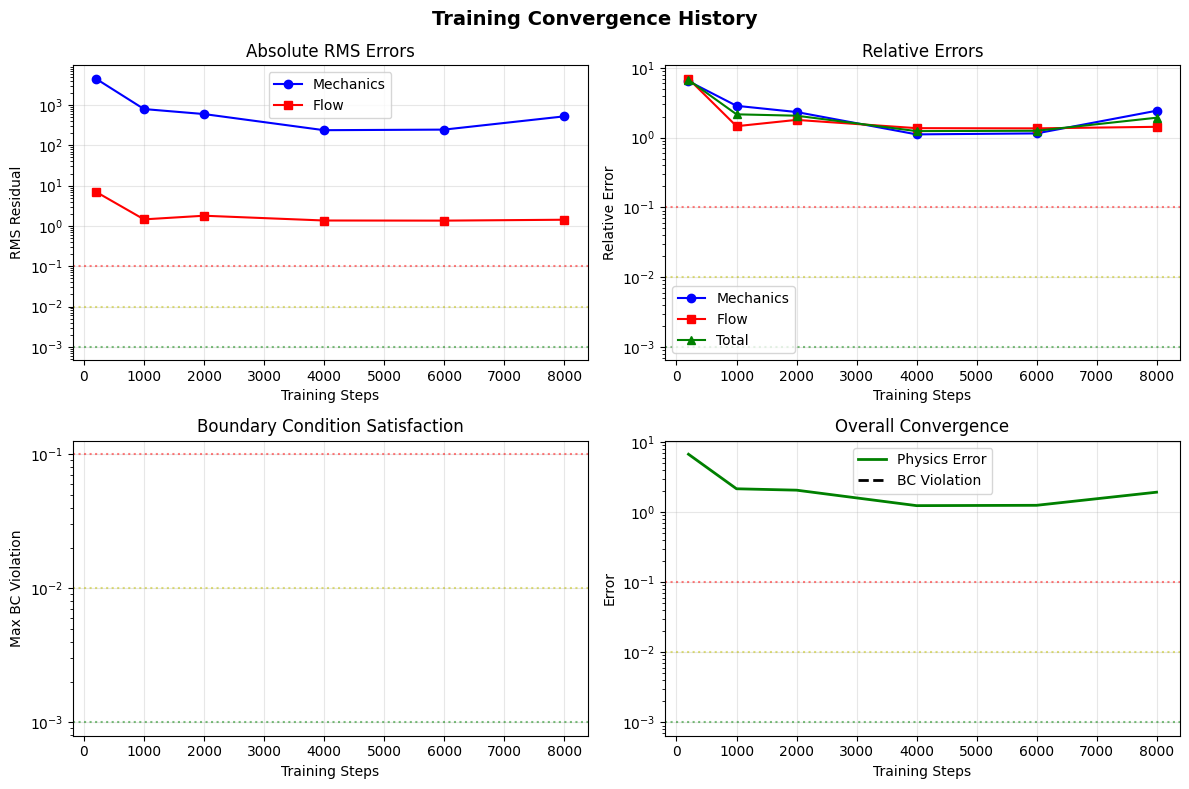



Test Points:
  (0.0, 0.5): ux=-0.0000, uy=0.0000, p=0.4547
  (1.0, 0.5): ux=-0.0433, uy=0.0077, p=0.0000
  (0.5, 0.0): ux=-0.0008, uy=0.0000, p=-0.0104


In [5]:
import jax.numpy as jnp

trainer = FixedTrainer()

#  staged schedule
history = trainer.track_convergence_history(
    checkpoint_steps=[200, 1000, 2000, 4000, 6000, 8000],
    save_checkpoints=True,
    checkpoint_dir="checkpoints"
)
# evaluate at a snapshot time
T_SNAPSHOT = 1.0

# probe some points
x_points = jnp.array([[0.0, 0.5], [1.0, 0.5], [0.5, 0.0]])
pred = trainer.predict(x_points, t=T_SNAPSHOT)
print("\nTest Points:")
print(f"  (0.0, 0.5): ux={pred[0,0]:.4f}, uy={pred[0,1]:.4f}, p={pred[0,2]:.4f}")
print(f"  (1.0, 0.5): ux={pred[1,0]:.4f}, uy={pred[1,1]:.4f}, p={pred[1,2]:.4f}")
print(f"  (0.5, 0.0): ux={pred[2,0]:.4f}, uy={pred[2,1]:.4f}, p={pred[2,2]:.4f}")


In [6]:
import glob
sorted(glob.glob("checkpoints/model_step_*.pkl"))


['checkpoints/model_step_1000.pkl',
 'checkpoints/model_step_200.pkl',
 'checkpoints/model_step_2000.pkl',
 'checkpoints/model_step_4000.pkl',
 'checkpoints/model_step_6000.pkl',
 'checkpoints/model_step_8000.pkl']

In [7]:
trainer.save_checkpoint("checkpoints/final_model_step_8000.pkl")


Checkpoint saved to checkpoints/final_model_step_8000.pkl


In [8]:
import glob, pickle, shutil
from fbpinns.trainers import FBPINNTrainer

def load_into_trainer(path):
    with open(path, "rb") as f:
        ckpt = pickle.load(f)
    t = FixedTrainer()
    t.config = ckpt["config"]
    t.trainer = FBPINNTrainer(t.config)
    t.all_params = ckpt["all_params"]
    return t

cands = sorted(glob.glob("checkpoints/model_step_*.pkl"))
if not cands:
    print("No intermediate checkpoints found. Only saving the final snapshot.")
else:
    best_path, best_err = None, float("inf")
    for p in cands:
        t = load_into_trainer(p)
        m = t.compute_physics_metrics(n_points=50, method='fd_xy_ad_t', t=1.0)
        if m["total_rel"] < best_err:
            best_path, best_err = p, m["total_rel"]
    print("Best by physics:", best_path, best_err)
    shutil.copy(best_path, "checkpoints/best_model_by_physics.pkl")


[INFO] 2025-08-11 19:43:40 - <fbpinns.constants.Constants object at 0x7917d2b42d90>
run: biot_coupled_2d
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': Array([0., 0., 0.], dtype=float32), 'xmax': Array([1., 1., 1.], dtype=float32)}
problem: <class '__main__.BiotCoupled2D'>
problem_init_kwargs: {'E': 5000.0, 'nu': 0.25, 'alpha': 0.8, 'k': 1.0, 'mu': 1.0, 'M': 100.0}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [Array([0. , 0.5, 1. ], dtype=float32), Array([0. , 0.5, 1. ], dtype=float32), Array([0. , 0.5, 1. ], dtype=float32)], 'subdomain_ws': [Array([0.8, 0.8, 0.8], dtype=float32), Array([0.8, 0.8, 0.8], dtype=float32), Array([0.8, 0.8, 0.8], dtype=float32)], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [3, 128, 128, 128, 3], 'activation': 'tanh'}
n_steps: 8000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
sche

In [9]:
import pickle, shutil

best = "checkpoints/model_step_4000.pkl"
shutil.copy(best, "checkpoints/best_by_physics.pkl")
print("Saved:", "checkpoints/best_by_physics.pkl")


Saved: checkpoints/best_by_physics.pkl


[INFO] 2025-08-11 19:49:00 - <fbpinns.constants.Constants object at 0x7917d2b437d0>
run: biot_coupled_2d
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': Array([0., 0., 0.], dtype=float32), 'xmax': Array([1., 1., 1.], dtype=float32)}
problem: <class '__main__.BiotCoupled2D'>
problem_init_kwargs: {'E': 5000.0, 'nu': 0.25, 'alpha': 0.8, 'k': 1.0, 'mu': 1.0, 'M': 100.0}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [Array([0. , 0.5, 1. ], dtype=float32), Array([0. , 0.5, 1. ], dtype=float32), Array([0. , 0.5, 1. ], dtype=float32)], 'subdomain_ws': [Array([0.8, 0.8, 0.8], dtype=float32), Array([0.8, 0.8, 0.8], dtype=float32), Array([0.8, 0.8, 0.8], dtype=float32)], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [3, 128, 128, 128, 3], 'activation': 'tanh'}
n_steps: 2000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
sche

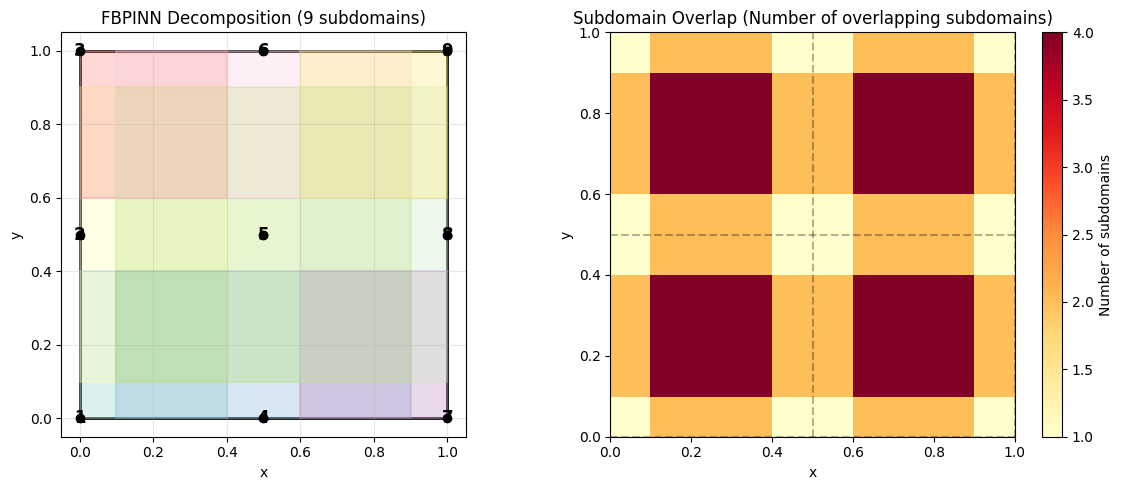


Boundary Conditon Verification at t=1.0
Left boundary (x=0): ux=0, uy=0, p=pL(y,t)
  max|ux| = 0.00e+00
  max|uy| = 0.00e+00
  max|p - pL| = 0.00e+00
Right boundary (x=1): p=0
  max|p| = 0.00e+00
Bottom boundary (y=0): uy=0
  max|uy| = 0.00e+00

Status: PERFECT - All BCs satisfied to machine precision


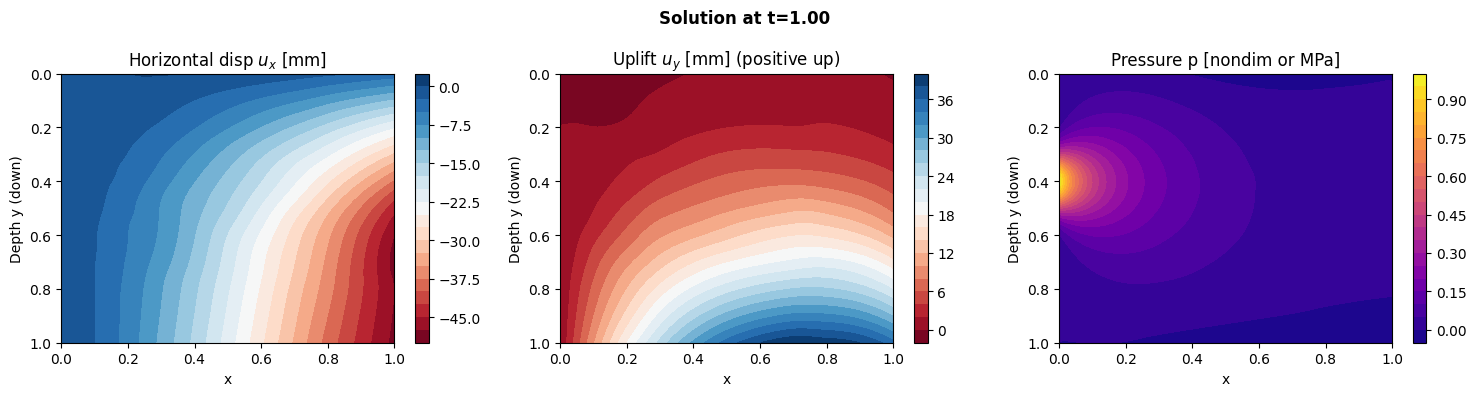

Physics Validation Metrics (using fd_xy_ad_t)

┌─────────────────┬──────────────┬──────────────┬──────────────┐
  │ Equation        │ RMS Absolute │ RMS Relative │ L-inf Norm   │
  ├─────────────────┼──────────────┼──────────────┼──────────────┤
 │ Mechanics (x)   │ 2.68e+02 │ 1.25e+00 │ 1.07e+03 │
 │ Mechanics (y)   │ 2.75e+02 │ 1.28e+00 │ 1.11e+03 │
 │ Mechanics (avg) │ 2.72e+02 │ 1.27e+00 │ 1.11e+03 │
 │ Flow            │ 1.08e+00 │ 1.08e+00 │ 1.67e+01 │
  └─────────────────┴──────────────┴──────────────┴──────────────┘

Characteristic Scales:
  Domain size (L): 1.00
  Pressure scale: 1.00
  Displacement scale: 4.29e-02
  Elastic force scale: 2.14e+02
  Flow scale (combined): 1.00e+00

Overall physics satisfaction: NEEDS IMPROVEMENT (avg relative error: 1.17e+00)
Best checkpoint total_rel: 1.1726617813110352


In [10]:
with open("checkpoints/best_by_physics.pkl", "rb") as f:
    ckpt = pickle.load(f)

trainer.all_params = ckpt["all_params"]
trainer.config     = ckpt["config"]

# FBPINN Trainer
from fbpinns.trainers import FBPINNTrainer
trainer.trainer = FBPINNTrainer(trainer.config)

# Visualization
T_SNAPSHOT = 1.0
trainer.visualize_domain_decomposition()
trainer.verify_bcs(n_points=100, t=T_SNAPSHOT)
trainer.plot_solution(n_points=100, t=T_SNAPSHOT, depth_style=True)
metrics = trainer.compute_physics_metrics(n_points=50, method='fd_xy_ad_t', t=1.0)
print("Best checkpoint total_rel:", metrics["total_rel"])


In [12]:
from google.colab import drive; drive.mount('/content/drive')
!mkdir -p "/content/drive/MyDrive/fbpinn_runs/2025-08-11"
!cp -r /content/FBPINNs/poroelasticity/checkpoints "/content/drive/MyDrive/fbpinn_runs/2025-08-11/"

Mounted at /content/drive
